In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
import datetime
import time

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
plt.style.use('ggplot')

# Function

In [2]:
def get_position(data):
    
    pos = [0, 0]

    for i in range(1, len(data)-1):

        #進場
        a = data.loc[i, 'ratio'] < data.loc[i, "percentile"]
        b = data.loc[i, "CLOSE"] < data.loc[i, 'vix_mean']
        e = data.loc[i, 'CLOSE'] != np.nan
        
        #出場
        c = data.loc[i, 'ratio'] > data.loc[i, "percentile"]
        d = data.loc[i, "CLOSE"] > data.loc[i, 'vix_mean']
        
        
        #加碼
#         g = data.loc[i, '最低價'] > data.loc[i, 'h']

        if pos[-1] == 0 :
            if (a&b&e) == True :
                pos.append(pos[-1] + 1)
            else :
                pos.append(pos[-1])

        #在持有部位的情況下
        elif pos[-1] != 0 :

            if c&d == True:
                pos.append(pos[-1] - pos[-1])
                
#             #加碼
#             elif g == True:
#                 pos.append(pos[-1]+1)
#                 #最多n口部位
#                 if pos[-1] >= 2:
#                     pos[-1] = 2
                
            else :
                pos.append(pos[-1])
                
    return pos

In [3]:
def dd(data, position, settle):
    
    principal = 1000000
    per = 200
    fee = 600
    
    date = np.array(data['date'])
    point = np.array(data['point'])
    pnl_list = [principal]

    for i in range(1, len(data)):
        if (position[i-1] == 0) & (position[i] == 0):
            pnl_list.append(0)
            
        #有買進要扣手續類
        elif (position[i-1] == 0) & (position[i] != 0):
            pnl_list.append(position[i]*(-fee))
            
        elif (position[i-1] != 0) & (position[i] != 0):
            
            if (position[i-1] != position[i]) :
                #轉倉加碼遠月的手續費計算
                if date[i] == date[i-1]:
                    pnl_list.append(position[i]*(point[i]*per - fee))
                #加碼手續費計算
                else :
                    pnl_list.append(position[i-1]*point[i]*per - fee)
            #轉倉手續費計算(無加碼已包含在內)
            elif date[i] in np.array(settle):
                pnl_list.append(position[i]*(point[i]*per - fee))
            else:
                pnl_list.append(position[i]*point[i]*per)
        
            
            #有賣出要扣手續費
        elif (position[i-1] != 0) & (position[i] == 0):
            pnl_list.append(position[i-1]*(point[i]*per - fee))

    #畫圖用資料        
    data['position'] = position
    data['pnl'] = pnl_list
    data['principal'] = data['pnl'].cumsum()
    data['high'] = data['principal'].cummax()
    data['dd'] = ((data['principal']-data['high']))/data['high']

    return data

In [4]:
def performance(data):
    
    principal = 1000000
    
    Return = (data.loc[data.index[-1], 'principal'] - principal)/principal
    MDD = np.round((-data['dd'].min()), 4)
    ret_to_MDD = np.round(Return/MDD, 2)

    ret_list = data['principal'].pct_change()
    mean_ret = np.mean(ret_list)*252
    std = (np.std(ret_list)*(252**0.5))
    sp = round((mean_ret / std), 4)

    per = {"Return" : Return, "MDD" : MDD, "Return to MDD" : ret_to_MDD, "Sharpe Ratio" : sp}
    
    return per

In [5]:
def plot(data, dictionary, name) :

    #new equity high
    eh = data[['date', 'high']]
    eh = eh.drop_duplicates('high', keep = 'first')
                            
    fig = plt.figure(figsize=(14, 6)) 
    plt.subplot(2, 1, 1)
    plt.grid(color = 'white')
    plt.title('{} Return&MDD'.format(name),fontsize=20)
    plt.plot(data['date'], data['principal'], color = 'red')
    plt.plot(eh['date'], eh['high'],'o',color = 'limegreen', alpha = 0.5)
    plt.legend(['Gain' , 'New equity high'], loc = 'best')
    plt.text(data['date'][data.index[-200]], data['principal'].min(), 'Return: {}%'.format(np.round(dictionary['Return'], 4)*100)+\
                                                                 "\nMDD: {}%".format(np.round(dictionary['MDD'], 4)*100)+\
                                                                 "\nReturn to MDD: {}".format(dictionary['Return to MDD'])+\
                                                                 "\nSharpe Ratio: {}".format(dictionary['Sharpe Ratio']), fontsize = 10, color='black')
#     plt.axvline(x = pd.to_datetime("2020-01-01"), color = "grey")  
    
    plt.subplot(2, 1, 2)
    plt.grid(color = 'white')
    plt.fill_between(data['date'], data['dd'], interpolate=True, color='red')
    plt.legend(['dd'], loc = 'upper left')
#     plt.axvline(x = pd.to_datetime("2020-01-01"), color = "grey")
    
    plt.show()

In [6]:
def get_year(date):
    
    y = []
    
    for i in range(len(date)):
        oneday = date[i]
        year = oneday.year
        y.append(year)
        
    return y

In [7]:
def get_month(date):
    
    m = []
    
    for i in range(len(date)):
        oneday = date[i]
        month = oneday.month
        m.append(month)
        
    return m

# Data Pre-Process

In [8]:
#台指資料
data = pd.read_csv(r"D:\TMBA\111-1\轉倉資料.csv")
data['date'] = pd.to_datetime(data['date'])

data['point'] = data['開盤價'].diff()

#轉倉遠月契約當作新部位
for i in range(1, len(data)):
    if data.loc[i, 'date'] == data.loc[i-1, 'date']:
        data.loc[i, 'point'] = 0

In [9]:
#結算日資料
sett = pd.read_csv("D:\TMBA\結算日.csv", encoding = 'ANSI')
sett['最後結算日'] = pd.to_datetime(sett['最後結算日'])

for i in range(len(sett)):
    if len(sett['契約月份'][i]) != 6:
        sett = sett.drop(i, axis = 0)
        
sett = sett['最後結算日']

In [10]:
vix = pd.read_csv("D:\TMBA\VIX_History.csv")
vix['date'] = pd.to_datetime(vix['date'])
vix = vix[['date', 'CLOSE']]

In [11]:
ms = pd.read_csv("D:\TMBA\整體市場融資融劵表.csv")
ms['date'] = pd.to_datetime(ms['date'])

mp = ms[ms['name'] == 'MarginPurchase'].reset_index(drop = True)
ss = ms[ms['name'] == 'ShortSale'].reset_index(drop = True)

r = pd.DataFrame(mp['date'], columns = ['date'])
# r['date'] = mp['date']
r['ratio'] = ss[['TodayBalance']] / mp[['TodayBalance']]

# Testing Set

In [12]:
r['percentile'] = r['ratio'].rolling(13).mean()
vix['vix_mean'] = vix['CLOSE'].rolling(20).mean()

In [13]:
data = pd.merge(data, r, on = 'date', how = 'left')
data = pd.merge(data, vix, on = 'date', how = 'left')

data = data[data['date'] >= "2010-01-01"].reset_index(drop = True)
# data = data[(data['date'] >= "2012-01-01") & (data['date'] <= "2014-01-01")].reset_index(drop = True)

In [14]:
data['position'] = get_position(data)

In [15]:
for i in range(1, len(data)-2):
    if data.loc[i, 'date'] == data.loc[i+1, 'date']:
        #結算日前一天出現買進訊號
        if ((data.loc[i-1, 'position'] == 0) & (data.loc[i, 'position'] == 1)):
            
            data.loc[i+1, 'position'] = data.loc[i, 'position']
            data.loc[i, 'position'] = data.loc[i, 'position'] - 1
            print("買進於 :{}".format(data.loc[i, 'date']))
            
        #結算日當天出現買出訊號    
        elif ((data.loc[i, 'position'] == 0) & (data.loc[i+1, 'position'] == 1)):
            data.loc[i+1, 'position'] = data.loc[i, 'position']
            print("結算日出現買進訊號 :{}".format(data.loc[i, 'date']))
        
        #結算日當天出現賣出訊號
        elif ((data.loc[i, 'position'] == 1) & (data.loc[i+1, 'position'] == 0)):
            data.loc[i+1, 'position'] = data.loc[i, 'position']
            data.loc[i+2, 'position'] = data.loc[i+1, 'position'] - 1
            print("結算日出現賣出訊號 :{}".format(data.loc[i, 'date']))
            
pos2 = data['position']

買進於 :2010-10-20 00:00:00
結算日出現買進訊號 :2010-12-15 00:00:00
結算日出現賣出訊號 :2011-01-19 00:00:00
結算日出現賣出訊號 :2015-12-16 00:00:00
結算日出現買進訊號 :2016-09-21 00:00:00
結算日出現賣出訊號 :2017-01-18 00:00:00
結算日出現買進訊號 :2018-02-21 00:00:00
結算日出現賣出訊號 :2022-01-19 00:00:00
買進於 :2022-03-16 00:00:00
買進於 :2022-10-19 00:00:00


In [16]:
data = dd(data, pos2, sett)

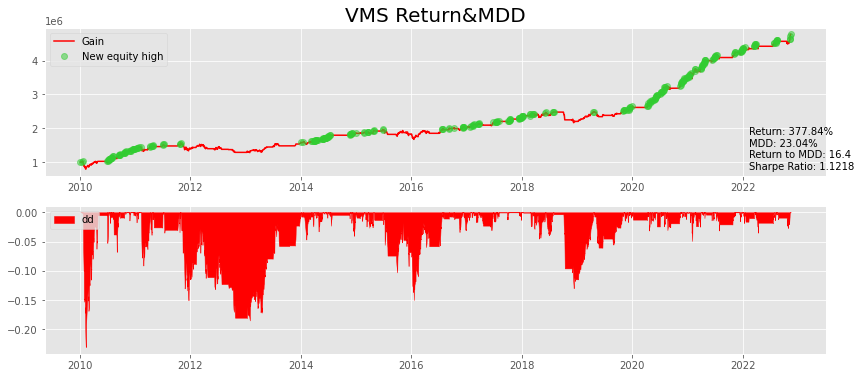

In [17]:
plot(data, performance(data), 'VMS')

In [18]:
b = 0
a = 0
s = 0

for i in range(1, len(data)):
    if (data.loc[i-1, 'position'] == 0) & (data.loc[i, 'position'] == 1):
        b += 1
    elif (data.loc[i, 'position'] != data.loc[i-1, 'position']) & (data.loc[i-1, 'position'] != 0) & (data.loc[i, 'position'] != 0):
        a += 1
    elif (data.loc[i-1, 'position'] != 0) & (data.loc[i, 'position'] == 0):
        s += 1
    
print("買進次數: {}".format(b), "\n加碼總次數: {}".format(a), "\n賣出總次數: {}".format(s))

買進次數: 66 
加碼總次數: 0 
賣出總次數: 65


In [19]:
principal = 1000000

Return = (data.loc[data.index[-1], 'principal'] - principal)/principal
MDD = np.round((-data['dd'].min()), 4)*100
ret_to_MDD = (np.round(Return/MDD, 4))*100
    
trade_price = []
date = []

for i in range(1, len(data)):
    if (data['position'][i-1] == 0) & (data['position'][i] == 1):
        trade_price.append(data['principal'][i-1])
        date.append(data['date'][i])
    elif (data['position'][i-1] != 0) & (data['position'][i] == 0) :
        trade_price.append(data['principal'][i])
        date.append(data['date'][i])

trade = pd.DataFrame(date, columns = ['date'])
trade['principal'] = trade_price

#sp
ret_list = data['principal'].pct_change()
mean_ret = (np.mean(ret_list))*252
std = (np.std(ret_list)*(252**0.5))
sp = np.round((mean_ret / std), 4)

#每筆交易資相關資料
trade_point = []
day = []

for i in range(1, len(trade), 2):
    #單次損益
    trade_point.append(np.round((trade['principal'][i]-trade['principal'][i-1]), 2))
    #單次持有時間
    date1 = datetime.datetime.strptime(str(trade['date'][i-1])[0:10], "%Y-%m-%d")
    date2 = datetime.datetime.strptime(str(trade['date'][i])[0:10], "%Y-%m-%d")
    num = (date2 - date1).days
    day.append(num)
    
#毛利毛損
g = list(filter(lambda x : x > 0, trade_point))
l = list(filter(lambda x : x < 0, trade_point))
pf = np.round(-np.sum(g) / np.sum(l), 4)

#勝率和交易次數
trade_times = len(trade_point)
    
if trade_times == 0 :
    win_rate = 0
elif trade_times != 0 :    
    win_rate = np.round(len(g)/(trade_times), 4)

#平均持有時間
mean_day = np.round(np.mean(day), 2)

print('Total Return: {}%'.format(np.round(Return*100, 4)) +\
          "\nMDD: {}%".format(MDD) +\
          "\nReturn to MDD: {}".format(ret_to_MDD) +\
          '\nAnnual Return: {}%'.format(np.round(mean_ret, 4)*100) +\
          "\nAnnual Volatility: {}%".format(np.round(std, 4)*100) +\
          "\nSharpe Ratio: {}".format(sp)+\
          "\nProfit factor: {}".format(pf) +\
          "\nWin rate: {}%".format(win_rate*100) +\
          "\nMean holding days: {} days".format(mean_day))

Total Return: 377.84%
MDD: 23.04%
Return to MDD: 16.400000000000002
Annual Return: 12.5%
Annual Volatility: 11.14%
Sharpe Ratio: 1.1218
Profit factor: 4.5969
Win rate: 73.85000000000001%
Mean holding days: 39.29 days


In [20]:
b = 0
a = 0
s = 0

for i in range(1, len(data)):
    if (data.loc[i-1, 'position'] == 0) & (data.loc[i, 'position'] == 1):
        b += 1
    elif (data.loc[i, 'position'] != data.loc[i-1, 'position']) & (data.loc[i-1, 'position'] != 0) & (data.loc[i, 'position'] != 0):
        a += 1
    elif (data.loc[i-1, 'position'] != 0) & (data.loc[i, 'position'] == 0):
        s += 1
    
print("買進次數: {}".format(b), "\n加碼總次數: {}".format(a), "\n賣出總次數: {}".format(s))

買進次數: 66 
加碼總次數: 0 
賣出總次數: 65


In [21]:
ddd = []
for i in range(1, len(data)):
    if (data.loc[i-1, 'dd'] == 0) & (data.loc[i, 'dd'] != 0):
        d1 =  datetime.datetime.strptime(str(data.loc[i, 'date'])[0:10], "%Y-%m-%d")
    elif (data.loc[i-1, 'dd'] != 0) & (data.loc[i, 'dd'] == 0):
        d2 = datetime.datetime.strptime(str(data.loc[i, 'date'])[0:10], "%Y-%m-%d")
        
        ddd.append((d2-d1).days)
        
print("權益未創高累積天數: {}天".format(np.max(ddd)))

權益未創高累積天數: 792天


C:\Users\User\AppData\Local\Temp\ipykernel_11068\1976497925.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['profit'] = trade_point


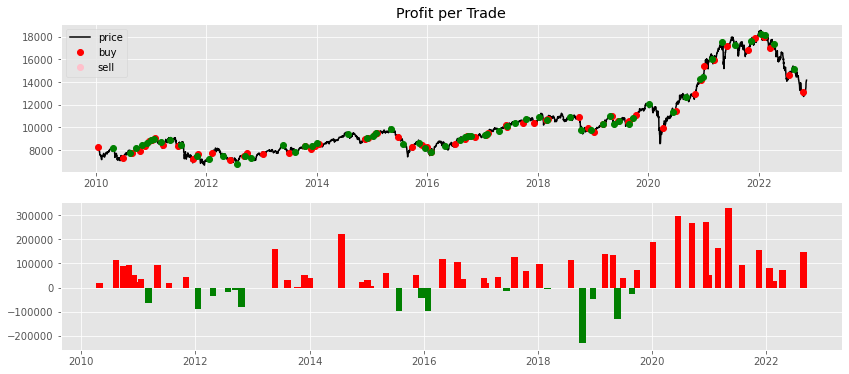

In [22]:
# 買賣訊號
buy_mark = [np.nan]
add_mark = [np.nan]
sell_mark = [np.nan]


for i in range(1, len(data)):
    if (data['position'][i-1] == 0) & (data['position'][i] != 0):
        buy_mark.append(data.loc[i, '開盤價'])
    else :
        buy_mark.append(np.nan)
        
for i in range(1, len(data)) : 
    if (data['position'][i-1] != 0) & (data['position'][i] != 0) & (data['position'][i] != data['position'][i-1]):
        add_mark.append(data.loc[i, '開盤價'])
    else :
        add_mark.append(np.nan)

        
for i in range(1, len(data)) : 
    if (data['position'][i-1] != 0) & (data['position'][i] == 0):
        sell_mark.append(data['開盤價'][i])
    else :
        sell_mark.append(np.nan)

#每次損益
a = trade.iloc[1::2]
a['profit'] = trade_point
a = a.reset_index(drop=True)

gain = a[a['profit'] > 0]
loss = a[a['profit'] < 0]

#畫圖
fig = plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.title('Profit per Trade')
plt.plot(data['date'], data['開盤價'], color = 'black')
plt.plot(data['date'], buy_mark, 'o', color='red', alpha = 1)
plt.plot(data['date'], add_mark, 'o', color='pink', alpha = 1)
plt.plot(data['date'], sell_mark, 'o', color='green', alpha = 1)
plt.legend(['price', 'buy' , 'sell'], loc = 'best')

plt.subplot(2, 1, 2)
plt.bar(gain['date'], gain['profit'], 40, align='center', color='r')
plt.bar(loss['date'], loss['profit'], 40, align='center', color='g')
plt.show()

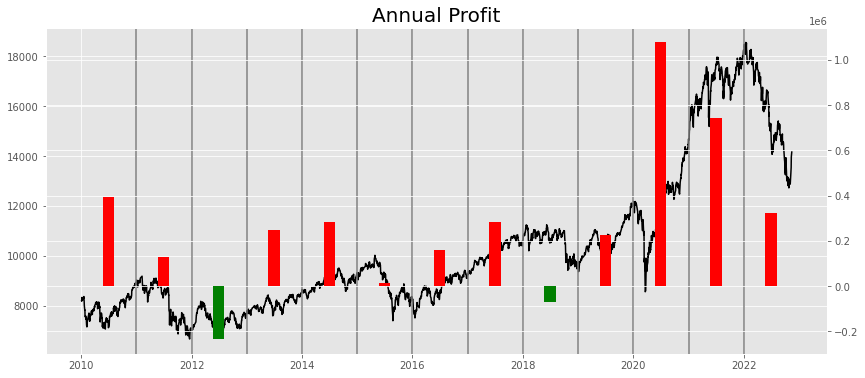

In [23]:
#不同市場下的損益
a['year'] = get_year(a['date'])
# a['month'] = get_month(a['date'])

profit_year = a[['date', 'profit']].groupby(pd.Grouper(key="date", freq="YS")).sum()
profit_year_gain = profit_year[profit_year['profit'] > 0]
profit_year_loss = profit_year[profit_year['profit'] < 0]

fig, ax1 = plt.subplots(figsize=(14, 6))
plt.grid(color = 'white')
plt.title('Annual Profit', fontsize=20)

ax2 = ax1.twinx()

ax1.plot(data['date'], data['開盤價'], color = 'black')

for i in profit_year.index[1:] : 
    ax1.axvline(x = i, color = "grey")  
ax1.tick_params(axis='y')


ax2.bar(profit_year_gain.index + datetime.timedelta(180) , profit_year_gain['profit'], 75,align='center', color='r')
ax2.bar(profit_year_loss.index + datetime.timedelta(180), profit_year_loss['profit'], 75, align='center', color='g')
ax2.tick_params(axis='y')

plt.show()